
# A Notebook to analyze downloaded gridded climate time-series data 

## (Case study:  the Sauk-Suiattle Watershed )
<img src= "http://www.sauk-suiattle.com/images/Elliott.jpg"
style="float:left;width:150px;padding:20px">   
This data is compiled to digitally observe the Sauk-Suiattle Watershed, powered by HydroShare. <br />
<br />
Use this Jupyter Notebook to: <br />
Migrate data sets from prior data download events,
Compute daily, monthly, and annual temperature and precipitation statistics, <br /> 
Visualize precipitation results relative to the forcing data, <br />
Visualize the time-series trends among the gridded cells using different Gridded data products. <br />

<br /> <br /> <br /> <img src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png" style="float:right;width:120px;padding:20px">  
#### A Watershed Dynamics Model by the Watershed Dynamics Research Group in the Civil and Environmental Engineering Department at the University of Washington 

## 1.  HydroShare Setup and Preparation

To run this notebook, we must import several libaries. These are listed in order of 1) Python standard libraries, 2) hs_utils library provides functions for interacting with HydroShare, including resource querying, dowloading and creation, and 3) the observatory_gridded_hydromet library that is downloaded with this notebook. 

In [1]:
#!conda install -c conda-forge basemap-data-hires --yes

In [2]:
# data processing
import os
import pandas as pd, numpy as np, dask, json
import geopandas as gpd
import ogh
import ogh_meta

# data migration library
from utilities import hydroshare

# plotting and shape libraries
import matplotlib.pyplot as plt
%matplotlib inline

# silencing warning
import warnings
warnings.filterwarnings("ignore")

In [3]:
# initialize ogh_meta
meta_file = ogh.ogh_meta()

sorted(meta_file.keys())

['dailymet_bclivneh2013',
 'dailymet_livneh2013',
 'dailymet_livneh2015',
 'dailyvic_livneh2013',
 'dailyvic_livneh2015',
 'dailywrf_bcsalathe2014',
 'dailywrf_salathe2014']

In [4]:
sorted(meta_file['dailymet_livneh2013'].keys())

['decision_steps',
 'delimiter',
 'domain',
 'end_date',
 'file_format',
 'filename_structure',
 'reference',
 'spatial_resolution',
 'start_date',
 'subdomain',
 'temporal_resolution',
 'variable_info',
 'variable_list',
 'web_protocol']

Establish a secure connection with HydroShare by instantiating the hydroshare class that is defined within hs_utils. In addition to connecting with HydroShare, this command also sets and prints environment variables for several parameters that will be useful for saving work back to HydroShare. 

In [5]:
notebookdir = os.getcwd()

hs=hydroshare.hydroshare()
homedir = hs.getContentPath(os.environ["HS_RES_ID"])
os.chdir(homedir)
print('Data will be loaded from and save to:'+homedir)

Adding the following system variables:
   HS_USR_NAME = jphuong
   HS_RES_ID = 70b977e22af544f8a7e5a803935c329c
   HS_RES_TYPE = genericresource
   JUPYTER_HUB_IP = jupyter.cuahsi.org

These can be accessed using the following command: 
   os.environ[key]

   (e.g.)
   os.environ["HS_USR_NAME"]  => jphuong
Successfully established a connection with HydroShare
Data will be loaded from and save to:/home/jovyan/work/notebooks/data/70b977e22af544f8a7e5a803935c329c/70b977e22af544f8a7e5a803935c329c/data/contents


If you are curious about where the data is being downloaded, click on the Jupyter Notebook dashboard icon to return to the File System view.  The homedir directory location printed above is where you can find the data and contents you will download to a HydroShare JupyterHub server.  At the end of this work session, you can migrate this data to the HydroShare iRods server as a Generic Resource. 

## 2. Get list of gridded climate points for the watershed

This example uses a shapefile with the watershed boundary of the Sauk-Suiattle Basin, which is stored in HydroShare at the following url: https://www.hydroshare.org/resource/c532e0578e974201a0bc40a37ef2d284/. 

The data for our processing routines can be retrieved using the getResourceFromHydroShare function by passing in the global identifier from the url above.  In the next cell, we download this resource from HydroShare, and identify that the points in this resource are available for downloading gridded hydrometeorology data, based on the point shapefile at https://www.hydroshare.org/resource/ef2d82bf960144b4bfb1bae6242bcc7f/, which is for the extent of North America and includes the average elevation for each 1/16 degree grid cell.  The file must include columns with station numbers, latitude, longitude, and elevation. The header of these columns must be FID, LAT, LONG_, and ELEV or RASTERVALU, respectively. The station numbers will be used for the remainder of the code to uniquely reference data from each climate station, as well as to identify minimum, maximum, and average elevation of all of the climate stations.  The webserice is currently set to a URL for the smallest geographic overlapping extent - e.g. WRF for Columbia River Basin (to use a limit using data from a FTP service, treatgeoself() would need to be edited in observatory_gridded_hydrometeorology utility). 

In [6]:
"""
Sauk
"""
# Watershed extent
hs.getResourceFromHydroShare('c532e0578e974201a0bc40a37ef2d284')
sauk = hs.content['wbdhub12_17110006_WGS84_Basin.shp']

# reproject the shapefile into WGS84
ogh.reprojShapefile(sourcepath=sauk)

This resource already exists in your userspace.
Would you like to overwrite this data [Y/n]? n


### Summarize the file availability from each watershed mapping file

In [7]:
# map the mappingfiles from usecase1
mappingfile1 = os.path.join(homedir,'Sauk_mappingfile.csv')

t1 = ogh.mappingfileSummary(listofmappingfiles = [mappingfile1], 
                            listofwatershednames = ['Sauk-Suiattle river'],
                            meta_file=meta_file)

t1

Watershed,Sauk-Suiattle river
Median elevation in meters [range](No. gridded cells),1171[164-2216] (n=99)
dailymet_livneh2013,1171[164-2216] (n=99)
dailymet_bclivneh2013,1171[164-2216] (n=99)
dailymet_livneh2015,1171[164-2216] (n=99)
dailyvic_livneh2013,1171[164-2216] (n=99)
dailyvic_livneh2015,1171[164-2216] (n=99)
dailywrf_salathe2014,1171[164-2216] (n=99)
dailywrf_bcsalathe2014,1171[164-2216] (n=99)


In [8]:
files=[]
files.append(mappingfile1)

## 3.  Compare Hydrometeorology 

This section performs computations and generates plots of the Livneh 2013, Livneh 2016, and WRF 2014 temperature and precipitation data in order to compare them with each other and observations. The generated plots are automatically downloaded and saved as .png files in the "plots" folder of the user's home directory and inline in the notebook.

In [9]:
# Livneh et al., 2013
dr1 = meta_file['dailymet_livneh2013']

# Livneh et al., 2015
dr2 = meta_file['dailymet_livneh2015']

# define overlapping time window
dr = ogh.overlappingDates(date_set1=tuple([dr1['start_date'], dr1['end_date']]), 
                          date_set2=tuple([dr2['start_date'], dr2['end_date']]))
dr

('1950-01-01', '2011-12-31')

### INPUT: gridded meteorology from Jupyter Hub folders
Data frames for each set of data are stored in a dictionary. The inputs to gridclim_dict() include the folder location and name of the hydrometeorology data, the file start and end, the analysis start and end, and the elevation band to be included in the analsyis (max and min elevation). <br/>  

#### Create a dictionary of climate variables for the long-term mean (ltm) using the default elevation option of calculating a high, mid, and low elevation average.  The dictionary here is initialized with the Livneh et al., 2013 dataset with a dictionary output 'ltm_3bands', which is used as an input to the second time we run gridclim_dict(), to add the Salathe et al., 2014 data to the same dictionary. 

In [10]:
%%time
ltm = ogh.gridclim_dict(mappingfile=mappingfile1,
                        metadata=meta_file,
                        dataset='dailyvic_livneh2013',
                        subset_start_date=dr[0],
                        subset_end_date=dr[1])

ltm = ogh.gridclim_dict(mappingfile=mappingfile1,
                        metadata=meta_file,
                        dataset='dailyvic_livneh2015',
                        subset_start_date=dr[0],
                        subset_end_date=dr[1],
                        df_dict=ltm)

Number of data files within elevation range (164.0:2216.0): 99
EVAP dataframe reading to start: 0:00:00.153099
EVAP dataframe reading complete:0:00:02.226093
RUNOFF dataframe reading to start: 0:00:02.376998
RUNOFF dataframe reading complete:0:00:03.813555
BASEFLOW dataframe reading to start: 0:00:03.964972
BASEFLOW dataframe reading complete:0:00:05.080590
SMTOP dataframe reading to start: 0:00:05.231570
SMTOP dataframe reading complete:0:00:06.350418
SMMID dataframe reading to start: 0:00:06.499869
SMMID dataframe reading complete:0:00:07.654454
SMBOT dataframe reading to start: 0:00:07.805982
SMBOT dataframe reading complete:0:00:08.921459
SWE dataframe reading to start: 0:00:09.070947
SWE dataframe reading complete:0:00:10.203557
WDEW dataframe reading to start: 0:00:10.364109
WDEW dataframe reading complete:0:00:11.610690
SENSIBLE dataframe reading to start: 0:00:11.761279
SENSIBLE dataframe reading complete:0:00:12.887193
LATENT dataframe reading to start: 0:00:13.037865
LATENT d

In [11]:
# explain the livneh et al. 2013 daily VIC variables
pd.DataFrame.from_dict(meta_file['dailyvic_livneh2013']['variable_info']).T

,desc,dtypes,units
BASEFLOW,Baseflow,float64,mm/s
DAY,day,int8,day
EVAP,"Total ET rate-- includes Canopy, Sub-canopy Ev...",float64,mm/s
GRNDFLUX,Net heat flux into ground,float64,W/m^2
LATENT,Net latent heat flux,float64,W/m^2
MONTH,month,int8,mo
PREC,Incoming precipitation rate,float64,mm/s
RADTEMP,Mean radiative surface temperature,float64,K
RNET,Net downward radiation flux,float64,W/m^2
RUNOFF,Runoff,float64,mm/s


In [12]:
pd.DataFrame.from_dict(meta_file['dailyvic_livneh2015']['variable_info']).T

,desc,dtypes,units
BASEFLOW,Baseflow,float64,mm/day
DAY,day,int8,day
EVAP,"Total ET rate-- includes Canopy, Sub-canopy Ev...",float64,mm/day
GRNDFLUX,Net heat flux into ground,float64,W/m^2
LATENT,Net latent heat flux,float64,W/m^2
MONTH,month,int8,mo
PETNATVEG,Potential Evapotranspiration from current vege...,float64,mm/day
PETSHORT,Potential Evapotranspiration from short crop (...,float64,mm/day
PETTALL,Potential Evapotranspiration from tall crop (A...,float64,mm/day
RNET,Net downward radiation flux,float64,W/m^2


In [13]:
# compute daily streamflow as a function of daily Baseflow and Runoff 
ltm['STREAMFLOW_dailyvic_livneh2013']=ltm['BASEFLOW_dailyvic_livneh2013']+ltm['RUNOFF_dailyvic_livneh2013']
ltm['STREAMFLOW_dailyvic_livneh2015']=ltm['BASEFLOW_dailyvic_livneh2015']+ltm['RUNOFF_dailyvic_livneh2015']

In [14]:
ltm['STREAMFLOW_dailyvic_livneh2013'].iloc[:10,:10]

,0,1,2,3,4,5,6,7,8,9
,48.53125,48.46875,48.46875,48.46875,48.46875,48.40625,48.40625,48.40625,48.40625,48.40625
,-121.59375,-121.46875,-121.53125,-121.59375,-121.65625,-121.09375,-121.15625,-121.21875,-121.28125,-121.34375
1950-01-01,0.000026,0.000022,0.000014,0.000012,0.000034,0.000019,0.000018,0.000023,0.000014,0.000025
1950-01-02,0.000025,0.000021,0.000014,0.000012,0.000034,0.000019,0.000017,0.000023,0.000014,0.000025
1950-01-03,0.000025,0.000021,0.000014,0.000012,0.000033,0.000019,0.000017,0.000022,0.000014,0.000024
1950-01-04,0.000024,0.000021,0.000014,0.000012,0.000033,0.000018,0.000017,0.000022,0.000014,0.000024
1950-01-05,0.000024,0.000020,0.000014,0.000012,0.000032,0.000018,0.000017,0.000021,0.000014,0.000023
1950-01-06,0.000023,0.000020,0.000014,0.000012,0.000032,0.000018,0.000016,0.000021,0.000014,0.000023
1950-01-07,0.000023,0.000020,0.000014,0.000012,0.000031,0.000018,0.000016,0.000020,0.000014,0.000022
1950-01-08,0.000022,0.000019,0.000014,0.000012,0.000030,0.000017,0.000016,0.000020,0.000014,0.000022


In [15]:
ltm['STREAMFLOW_dailyvic_livneh2015'].iloc[:10,:10]

,0,1,2,3,4,5,6,7,8,9
,48.53125,48.46875,48.46875,48.46875,48.46875,48.40625,48.40625,48.40625,48.40625,48.40625
,-121.59375,-121.46875,-121.53125,-121.59375,-121.65625,-121.09375,-121.15625,-121.21875,-121.28125,-121.34375
1950-01-01,3.181068,5.442865,4.195510,3.272749,5.434286,1.104402,1.097558,1.696530,1.126341,1.450928
1950-01-02,3.097995,5.260791,4.096225,3.197714,5.274700,1.100741,1.094534,1.672896,1.123075,1.440227
1950-01-03,3.016081,5.073238,3.999203,3.123492,5.109202,1.097287,1.091715,1.649311,1.120047,1.428974
1950-01-04,2.936056,4.884651,3.892078,3.043275,4.935607,1.094036,1.089072,1.626051,1.117230,1.417413
1950-01-05,2.858365,4.700037,3.781022,2.961180,4.761339,1.090988,1.086574,1.603278,1.114604,1.405722
1950-01-06,2.783263,4.521905,3.681248,2.968932,4.591237,1.088139,1.084216,1.581036,1.112165,1.394034
1950-01-07,2.710885,4.351459,3.559529,2.915103,4.424686,1.085474,1.081996,1.559390,1.109897,1.382450
1950-01-08,2.641282,4.189186,3.452314,2.724442,4.265516,1.082955,1.079914,1.538392,1.107748,1.371048


In [16]:
# # correct the units from mm/day to mm/s
# ltm['STREAMFLOW_dailyvic_livneh2015'] = ltm['STREAMFLOW_dailyvic_livneh2015']/(24*60*60)
# ltm['STREAMFLOW_dailyvic_livneh2015'].iloc[:10,:10]

# correct the units from mm/s to mm/day
ltm['STREAMFLOW_dailyvic_livneh2013'] = ltm['STREAMFLOW_dailyvic_livneh2013']*(24*60*60)
ltm['STREAMFLOW_dailyvic_livneh2013'].iloc[:10,:10]

,0,1,2,3,4,5,6,7,8,9
,48.53125,48.46875,48.46875,48.46875,48.46875,48.40625,48.40625,48.40625,48.40625,48.40625
,-121.59375,-121.46875,-121.53125,-121.59375,-121.65625,-121.09375,-121.15625,-121.21875,-121.28125,-121.34375
1950-01-01,2.220767,1.887025,1.208046,1.007829,2.933354,1.663324,1.525911,2.012581,1.245449,2.191471
1950-01-02,2.171374,1.856072,1.214886,1.010145,2.919672,1.638104,1.503216,1.966347,1.237176,2.137775
1950-01-03,2.124134,1.825559,1.218417,1.011535,2.886070,1.613869,1.481490,1.922471,1.229192,2.086780
1950-01-04,2.078936,1.795709,1.219754,1.012343,2.841513,1.590576,1.460688,1.880810,1.221488,2.038321
1950-01-05,2.035678,1.766647,1.219568,1.012756,2.790749,1.568180,1.440767,1.841234,1.214055,1.992241
1950-01-06,1.994264,1.738441,1.218293,1.012884,2.736558,1.546642,1.421685,1.803622,1.206884,1.948401
1950-01-07,1.954604,1.711126,1.216223,1.038548,2.680667,1.525924,1.403406,1.767861,1.199966,1.906667
1950-01-08,1.916611,1.684717,1.213571,1.012545,2.624200,1.505989,1.385892,1.733849,1.193293,1.866919


In [17]:
# # compute the mean gridded cell area
# gcSA, gcSA_sd = ogh.computeGCSurfaceArea(shapefile=sauk, 
#                                          spatial_resolution=1/16,
#                                          vardf=ltm['STREAMFLOW_dailyvic_livneh2013'])

# gcSA, gcSA_sd

In [18]:
# # plot the distribution of total monthly precipitation by month across stations

# # Exceedance Probability
# for exceedance in [0.01, 0.1, 1, 10]:

#     # compute exceedance probability (Livneh 2013)
#     ltm = ogh.monthlyExceedence_cfs(df_dict=ltm,
#                                     daily_streamflow_dfname='STREAMFLOW_dailyvic_livneh2013',
#                                     gridcell_area=gcSA,
#                                     exceedance=exceedance)
    
#     # compute exceedance probability (Livneh 2015)
#     ltm = ogh.monthlyExceedence_cfs(df_dict=ltm,
#                                     daily_streamflow_dfname='STREAMFLOW_dailyvic_livneh2015',
#                                     gridcell_area=gcSA,
#                                     exceedance=exceedance)

    
    
#     # designate output file path
#     outfile=os.path.join(homedir, 'SaukExceedance{0}_livneh2013.png'.format(exceedance))
#     files.append(outfile)
    
#     # render monthly exceedance probability distributions
#     ogh.renderValueInBoxplot(vardf=ltm['EXCEED{0}_dailyvic_livneh2013'.format(exceedance)],
#                              vmin=ltm['EXCEED{0}_dailyvic_livneh2015'.format(exceedance)].as_matrix().min(),
#                              vmax=ltm['EXCEED{0}_dailyvic_livneh2015'.format(exceedance)].as_matrix().max(),
#                              outfilepath=outfile,
#                              plottitle='Sauk-Suiattle {0}% Exceedance Probability\nLivneh et al. 2013'.format(exceedance),
#                              time_steps='month',
#                              wateryear=True,
#                              value_name='{0}% Exceedance Probability (cfs)'.format(exceedance),
#                              cmap='seismic_r',
#                              figsize=(15,6))
    
    
    
#     # designate output file path
#     outfile=os.path.join(homedir, 'SaukExceedance{0}_livneh2015.png'.format(exceedance))
#     files.append(outfile)
    
#     # render monthly exceedance probability distributions
#     ogh.renderValueInBoxplot(vardf=ltm['EXCEED{0}_dailyvic_livneh2015'.format(exceedance)],
#                              vmin=ltm['EXCEED{0}_dailyvic_livneh2015'.format(exceedance)].as_matrix().min(),
#                              vmax=ltm['EXCEED{0}_dailyvic_livneh2015'.format(exceedance)].as_matrix().max(),
#                              outfilepath=outfile,
#                              plottitle='Sauk-Suiattle {0}% Exceedance Probability\nLivneh et al. 2015'.format(exceedance),
#                              time_steps='month',
#                              wateryear=True,
#                              value_name='{0}% Exceedance Probability (cfs)'.format(exceedance),
#                              cmap='seismic_r',
#                              figsize=(15,6))

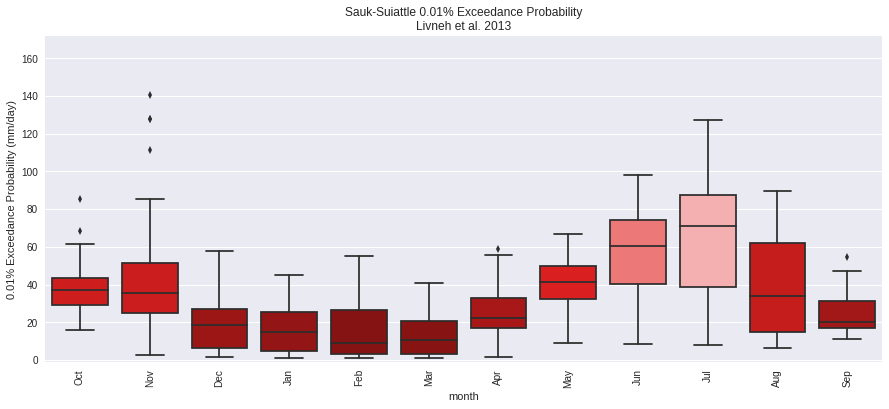

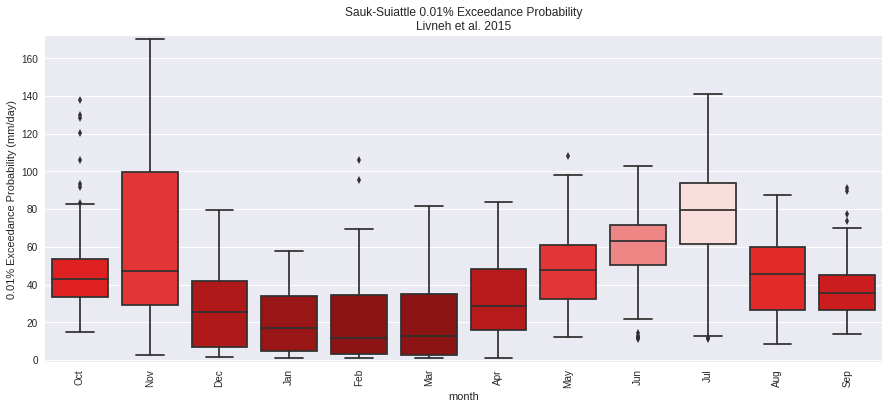

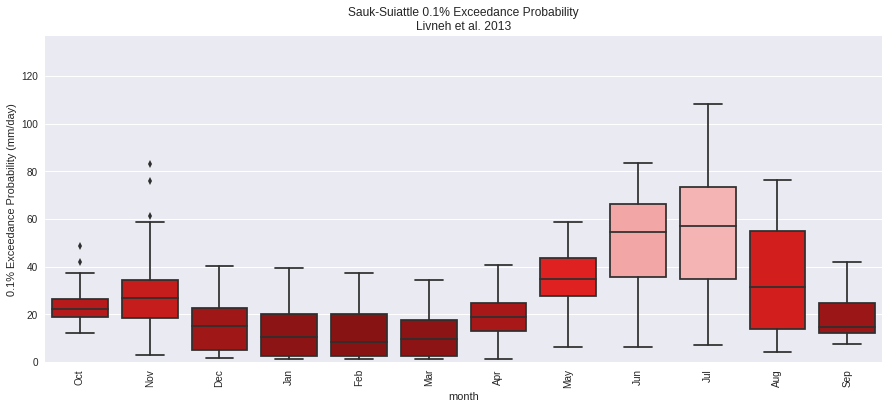

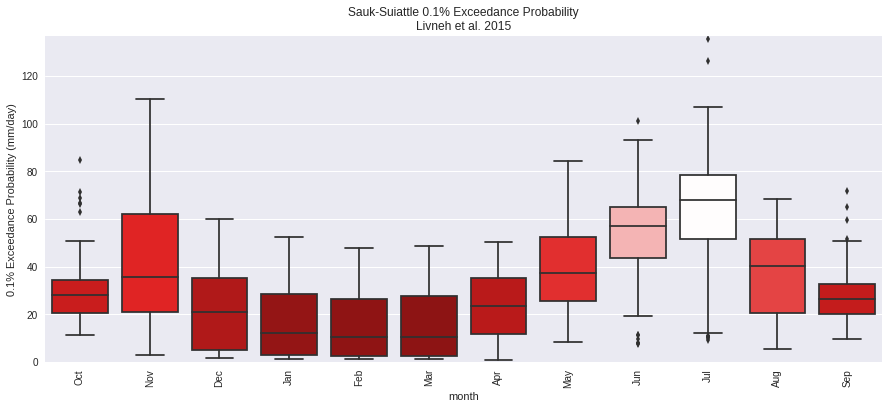

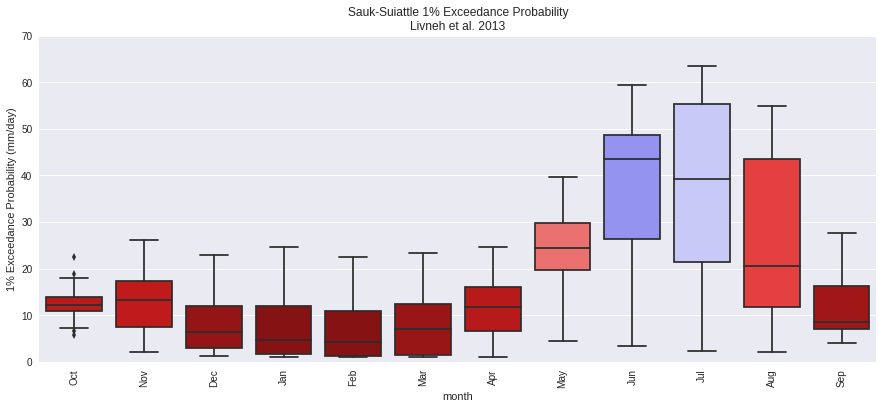

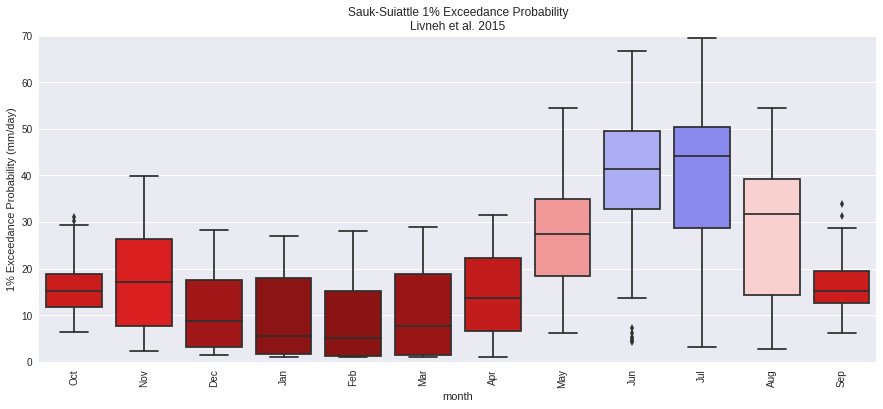

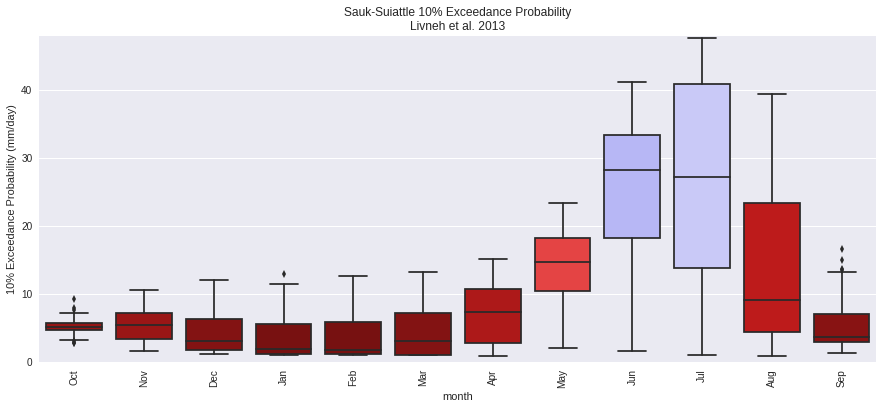

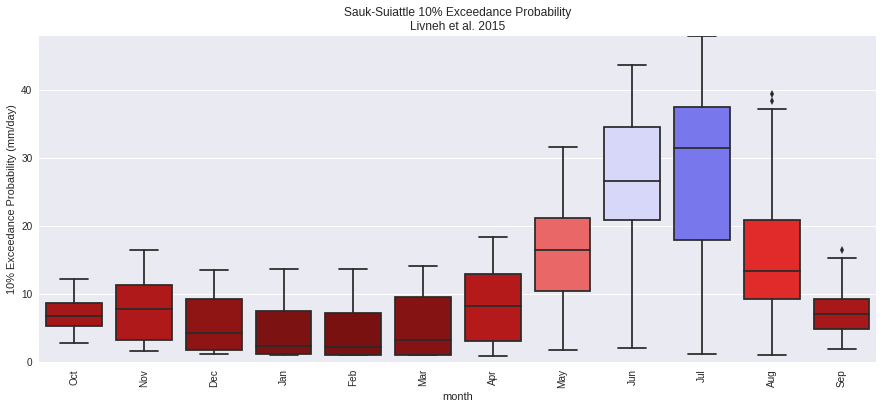

In [19]:
#### redo for mm/day as the exceedance probability from runoff
# plot the distribution of total monthly precipitation by month across stations

# Exceedance Probability
for exceedance in [0.01, 0.1, 1, 10]:

    # compute exceedance probability (Livneh 2013)
    ltm = ogh.monthlyExceedence_mmday(df_dict=ltm,
                                    daily_streamflow_dfname='STREAMFLOW_dailyvic_livneh2013',
                                    exceedance=exceedance)
    
    # compute exceedance probability (Livneh 2015)
    ltm = ogh.monthlyExceedence_mmday(df_dict=ltm,
                                    daily_streamflow_dfname='STREAMFLOW_dailyvic_livneh2015',
                                    exceedance=exceedance)

    
    
    # designate output file path
    outfile=os.path.join(homedir, 'SaukExceedance{0}_livneh2013.png'.format(exceedance))
    files.append(outfile)
    
    # render monthly exceedance probability distributions
    ogh.renderValueInBoxplot(vardf=ltm['EXCEED{0}_mmday_dailyvic_livneh2013'.format(exceedance)],
                             vmin=ltm['EXCEED{0}_mmday_dailyvic_livneh2015'.format(exceedance)].as_matrix().min(),
                             vmax=ltm['EXCEED{0}_mmday_dailyvic_livneh2015'.format(exceedance)].as_matrix().max(),
                             outfilepath=outfile,
                             plottitle='Sauk-Suiattle {0}% Exceedance Probability\nLivneh et al. 2013'.format(exceedance),
                             time_steps='month',
                             wateryear=True,
                             value_name='{0}% Exceedance Probability (mm/day)'.format(exceedance),
                             cmap='seismic_r',
                             figsize=(15,6))
    
    
    
    # designate output file path
    outfile=os.path.join(homedir, 'SaukExceedance{0}_livneh2015.png'.format(exceedance))
    files.append(outfile)
    
    # render monthly exceedance probability distributions
    ogh.renderValueInBoxplot(vardf=ltm['EXCEED{0}_mmday_dailyvic_livneh2015'.format(exceedance)],
                             vmin=ltm['EXCEED{0}_mmday_dailyvic_livneh2015'.format(exceedance)].as_matrix().min(),
                             vmax=ltm['EXCEED{0}_mmday_dailyvic_livneh2015'.format(exceedance)].as_matrix().max(),
                             outfilepath=outfile,
                             plottitle='Sauk-Suiattle {0}% Exceedance Probability\nLivneh et al. 2015'.format(exceedance),
                             time_steps='month',
                             wateryear=True,
                             value_name='{0}% Exceedance Probability (mm/day)'.format(exceedance),
                             cmap='seismic_r',
                             figsize=(15,6))


In [ ]:
# # loop through each month to compute the 10% Exceedance Probability
# for eachmonth in [10, 11, 7]:
#     monthlabel = pd.datetime.strptime(str(eachmonth), '%m')

#     # generate outfile path
#     outfile=os.path.join(homedir,'sauk{0}exceed0.01_livneh2013.png'.format(monthlabel.strftime('%b')))
#     files.append(outfile)
    
#     # render spatial map
#     ogh.renderValuesInPoints(vardf=ltm['EXCEED0.01_dailyvic_livneh2013'],
#                              vardf_dateindex=eachmonth, 
#                              shapefile=sauk,
#                              outfilepath=outfile, 
#                              plottitle='Sauk {0} 0.01% Exceedance Probability'.format(monthlabel.strftime('%B')),
#                              colorbar_label='cubic feet per second',
#                              cmap='seismic_r')

In [ ]:
# # loop through each month to compute the 10% Exceedance Probability
# for eachmonth in [10, 11, 1, 2, 4, 5, 7, 8]:
#     monthlabel = pd.datetime.strptime(str(eachmonth), '%m')

#     # generate outfile path
#     outfile=os.path.join(homedir,'sauk{0}exceed0.01_livneh2013.png'.format(monthlabel.strftime('%b')))
#     files.append(outfile)
    
#     # render spatial map
#     ogh.renderValuesInPoints_scale(vardf=ltm['EXCEED0.01_dailyvic_livneh2013'],
#                                    vardf_dateindex=eachmonth, 
#                                    shapefile=sauk,
#                                    outfilepath=outfile, 
#                                    plottitle='Sauk {0} 0.01% Exceedance Probability'.format(monthlabel.strftime('%B')),
#                                    colorbar_label='cubic feet per second',
#                                    vardfmax=ltm['EXCEED0.01_dailyvic_livneh2013'].as_matrix().max(),
#                                    vardfmin=ltm['EXCEED0.01_dailyvic_livneh2013'].as_matrix().min(),
#                                    cmap='seismic_r')

In [ ]:
# # compute average computations for streamflow in cfs units
# ltm=ogh.aggregate_space_time_average(df_dict=ltm,
#                                      suffix='cfs_STREAMFLOW_dailyvic_livneh2013',
#                                      start_date=ltm['cfs_STREAMFLOW_dailyvic_livneh2013'].index[0],
#                                      end_date=ltm['cfs_STREAMFLOW_dailyvic_livneh2013'].index[-1])

# # compute average computations for streamflow in cfs units
# ltm=ogh.aggregate_space_time_average(df_dict=ltm,
#                                      suffix='cfs_STREAMFLOW_dailyvic_livneh2015',
#                                      start_date=ltm['cfs_STREAMFLOW_dailyvic_livneh2015'].index[0],
#                                      end_date=ltm['cfs_STREAMFLOW_dailyvic_livneh2015'].index[-1])

# sorted(ltm.keys())

In [ ]:
# # generate the plot dimensions
# ax1 = plt.subplot(1,1,1)

# # plot the average daily streamflow by year
# ltm['year_cfs_STREAMFLOW_dailyvic_livneh2013'].plot(legend=False, figsize=(16,5), ax=ax1)

# # set yaxis label
# ax1.set_ylabel('Average daily streamflow (cfs)')

# # arrange the xaxis xtick labels
# ax1.set_xticks(ticks=ltm['year_cfs_STREAMFLOW_dailyvic_livneh2013'].index)
# ax1.xaxis.set_ticklabels(ticklabels=ltm['year_cfs_STREAMFLOW_dailyvic_livneh2013'].index, rotation=90)

# # set title
# ax1.set_title('Sauk-Suiattle Average daily streamflow (cfs) by year')
# outfile=os.path.join(homedir,'average_daily_streamflow_annually.png')
# files.append(outfile)
# plt.savefig(outfile)
# plt.show()

In [ ]:
# # generate the plot dimensions
# ax2 = plt.subplot(1,1,1)

# # plot the max daily streamflow across stations by year
# df = ltm['cfs_STREAMFLOW_dailyvic_livneh2013'].groupby(ltm['cfs_STREAMFLOW_dailyvic_livneh2013'].index.year).max()
# df.plot(legend=False, figsize=(16,5), ax=ax2, alpha=0.4)

# # add the highest streamflow across stations
# df.max(axis=1).plot(legend=False, color='r', ax=ax2)

# # set yaxis label
# ax2.set_ylabel('Max annual streamflow (cfs)')

# # arrange the xaxis xtick labels
# ax2.set_xticks(ticks=df.index)
# ax2.xaxis.set_ticklabels(ticklabels=df.index, rotation=90)

# # set title
# ax2.set_title('Sauk-Suiattle Max annual streamflow (cfs) by year')

# outfile=os.path.join(homedir,'max_streamflow_annually.png')
# files.append(outfile)
# plt.savefig(outfile)
# plt.show()

## 10. Save the results back into HydroShare
<a name="creation"></a>

Using the `hs_utils` library, the results of the Geoprocessing steps above can be saved back into HydroShare.  First, define all of the required metadata for resource creation, i.e. *title*, *abstract*, *keywords*, *content files*.  In addition, we must define the type of resource that will be created, in this case *genericresource*.  

***Note:*** Make sure you save the notebook at this point, so that all notebook changes will be saved into the new HydroShare resource.

In [ ]:
# save the dictionary of dataframes
outfile=os.path.join(homedir, 'ltm_livneh2013vic.json')
files.append(outfile)

ogh.saveDictOfDf(dictionaryObject=ltm, outfilepath=outfile)

len(files)

In [ ]:
# for each file downloaded onto the server folder, move to a new HydroShare Generic Resource
title = 'Exceedance Probability within Sauk-Suiattle'
abstract = 'This the output from the TreatGeoSelf utility integration notebook.'
keywords = ['Sauk', 'climate', 'Streamflow','flood risk prediction','hydromet','watershed'] 
rtype = 'genericresource'  

# create the new resource
resource_id = hs.createHydroShareResource(title=title,
                                          abstract=abstract,
                                          keywords=keywords,
                                          resource_type=rtype,
                                          content_files=files,
                                          public=False)